# Problem Formulation
The objective of this project is to develop a predictive model that optimise online food order feedback by encouraging more positive ratings and minimise negative ratings. By analyzing various factors influencing customer feedback, the goal is to identify strategies to increase overall positive feedback rates on the platform.

In [148]:
import pandas as pd
import plotly.express as px
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.utils import resample
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from scipy.stats import chi2_contingency
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.feature_selection import RFE

# Data Cleaning
Remove duplicate entries and any columns lacking proper identifiers. Furthermore, we identify and exclude variables that are irrelevant for our investigation.

In [149]:
df = pd.read_csv('onlinefoods.csv')
df.head()

,Age,Gender,Marital Status,Occupation,Monthly Income,Educational Qualifications,Family size,latitude,longitude,Pin code,Output,Feedback,Unnamed: 12
0,20,Female,Single,Student,No Income,Post Graduate,4,12.9766,77.5993,560001,Yes,Positive,Yes
1,24,Female,Single,Student,Below Rs.10000,Graduate,3,12.9770,77.5773,560009,Yes,Positive,Yes
2,22,Male,Single,Student,Below Rs.10000,Post Graduate,3,12.9551,77.6593,560017,Yes,Negative,Yes
3,22,Female,Single,Student,No Income,Graduate,6,12.9473,77.5616,560019,Yes,Positive,Yes
4,22,Male,Single,Student,Below Rs.10000,Post Graduate,4,12.9850,77.5533,560010,Yes,Positive,Yes


Remove duplicates, unnamed column and insignificant columns

In [150]:
df = df.drop_duplicates() 
df = df.loc[:, ~df.columns.str.contains('^Unnamed')] 
df = df.drop(columns=['latitude', 'longitude', 'Pin code']) 
df.head()

,Age,Gender,Marital Status,Occupation,Monthly Income,Educational Qualifications,Family size,Output,Feedback
0,20,Female,Single,Student,No Income,Post Graduate,4,Yes,Positive
1,24,Female,Single,Student,Below Rs.10000,Graduate,3,Yes,Positive
2,22,Male,Single,Student,Below Rs.10000,Post Graduate,3,Yes,Negative
3,22,Female,Single,Student,No Income,Graduate,6,Yes,Positive
4,22,Male,Single,Student,Below Rs.10000,Post Graduate,4,Yes,Positive


Check for null values

In [151]:
null_values = df.isnull().sum().sum()
print(null_values)

0


Generate descriptive statistics for numeric columns

In [152]:
numeric_df = df.select_dtypes(include=['int64', 'float64'])
numeric_df.describe().round(2)

,Age,Family size
count,285.00,285.00
mean,24.68,3.27
std,3.04,1.36
min,18.00,1.00
25%,23.00,2.00
50%,24.00,3.00
75%,26.00,4.00
max,33.00,6.00


# Exploratory Data Analysis

Performing data visualization on both categorical and numeric variables helps us understand the distribution, relationships and trends within the dataset

**Age** (Numerical Predictor)

In [153]:
fig = px.box(df, x='Age', y='Feedback', color='Feedback', title="Online food orders' feedbacks based on Age")
fig.update_xaxes(title_text='Age')
fig.update_yaxes(title_text='Feedback')
fig.update_layout(title_x=0.5)
fig.show()

From this, we can deduce that younger customers, particularly those between 22 and 26 years old, tend to provide more positive feedback, while negative feedback tends to come from slightly older customers, with the age between 23 to 28 years old.

By categorising the customers into age groups, we gain a different perspective on their feedback patterns

In [154]:
bins = [0, 20, 25, 30, 35]
labels = ['<20', '21-25', '26-30', '31-35']
df['Age Group'] = pd.cut(df['Age'], bins=bins, labels=labels, right=False)
feedback_by_age_group = df.groupby(['Age Group', 'Feedback'])['Feedback'].count().unstack()
fig = px.bar(feedback_by_age_group, barmode='group', color_discrete_sequence=['red', 'blue'],
             title="Online food orders' feedbacks based on Age Groups")
fig.update_yaxes(title_text='Count')
fig.update_layout(title_x=0.5)
fig.show()

**Family Size** (Numerical Predictor)

In [155]:
feedback_by_family_size = df.groupby(['Family size', 'Feedback'])['Feedback'].count().unstack()
fig = px.bar(feedback_by_family_size, 
             barmode='group',  
             color_discrete_sequence=['red', 'blue'],  
             title="Online food orders' feedbacks based on Family Size") 
fig.update_yaxes(title_text='Count')  
fig.update_layout(title_x=0.5) 
fig.show()  

Looking at the bar graph, it seems like the family of 3 gives the highest number of positive outcomes. However, it also has the highest number of negative outcomes. We should examine the positive to negative ratio for each family size.

In [156]:
feedback_by_family_size['Positive to Negative Ratio'] = feedback_by_family_size['Positive'] / feedback_by_family_size['Negative ']
fig_ratio = px.bar(feedback_by_family_size, 
                   y='Positive to Negative Ratio', 
                   color_discrete_sequence=['light blue'],  
                   title="Positive to Negative Ratio of Online Food Orders' Feedbacks by Family Size") 
fig_ratio.update_yaxes(title_text='Positive to Negative Ratio')  
fig_ratio.update_layout(title_x=0.5) 
fig_ratio.show()

Family of 4 show a higher positive to negative feedback ratio, while larger families with 5 to 6 members tend to give less positive feedback. Possible reasons may be cost effectiveness and meal sharing, leading to more positive feedback given

**Gender** (Categorial Predictor)

In [157]:
feedback_by_gender = df.groupby(['Gender', 'Feedback'])['Feedback'].count().unstack()

fig = px.bar(feedback_by_gender, barmode='group', color_discrete_sequence=['red', 'blue'],
             title="Online food orders' feedbacks based on Gender")
fig.update_yaxes(title_text='Count')
fig.update_layout(title_x=0.5)
fig.show()

From this observation, there appears to be a higher number of positive feedbacks in both genders.

**Monthly Income** (Categorical Predictor)

In [158]:
custom_order = ['No Income', 'Below Rs.10000', '10001 to 25000', '25001 to 50000', 'More than 50000']
df['Monthly Income'] = pd.Categorical(df['Monthly Income'], categories=custom_order, ordered=True)
feedback_by_income = df.groupby(['Monthly Income', 'Feedback'])['Feedback'].count().unstack()
fig = px.bar(feedback_by_income, barmode='group', color_discrete_sequence=['red', 'blue'],
             title="Online food orders' feedbacks based on Monthly Income")
fig.update_yaxes(title_text='Count')
fig.update_layout(title_x=0.5)
fig.show()

There appears to be a slight increment in positive feedback as monthly income increases. However, it is notable that the category "No Income" gives the most positive feedback

Regardless of the monthly income, the overall trend indicates that feedback provided is generally positive. This suggests that factors beyond income, such as food quality, delivery experience, or customer service, may have a more significant impact on feedback

**Occupation** (Categorical Predictor)

In [159]:
custom_order = ['House wife', 'Self Employeed', 'Employee', 'Student']
fig = px.bar(df.groupby(['Occupation', 'Feedback'])['Feedback'].count().unstack(), 
             color_discrete_sequence=['red', 'blue'],   
             title="Online food orders' feedbacks based on Occupation",
             category_orders={'Occupation': custom_order})  # Specify custom order
fig.update_yaxes(title_text='Count')
fig.update_layout(title_x=0.5)
fig.show()

The figure illustrates that students have the greatest tendency to provide positive feedback on online food orders. However, this observation may not solely reflect their satisfaction with the order. It could be influenced by other factors such as budget constraints, convenience and limited alternatives in school.

**Marital Status** (Categorical Predictor)

In [160]:
fig = px.bar(df.groupby(['Marital Status','Feedback'])['Feedback'].count().unstack(), color_discrete_sequence=['red','blue'],   title="Online food orders' feedbacks based on Marital Status")
fig.update_yaxes(title_text='Count')
fig.update_layout(title_x=0.5)
fig.show()

It is evident that singles provide more positive feedback compared to married individuals. This suggests that marital status may have an influence on the likelihood of leaving positive feedback for online food orders.

**Educational Qualifications** (Categorical Predictor)

In [161]:
edu_feedback_count = df.groupby(['Educational Qualifications', 'Feedback'])['Feedback'].count().unstack()
fig = px.bar(edu_feedback_count, 
             color_discrete_sequence=['red', 'blue'],
             title="Online food orders' feedbacks based on Educational Qualifications",
             labels={"Educational Qualifications": "Educational Qualifications", "value": "Count"},
             )
fig.update_yaxes(title_text='Count')
fig.update_layout(title_x=0.5)
fig.show()

In the case of educational qualifications, it is evident that individuals with Graduate and Post Graduate qualifications have the highest number of both positive and negative feedback. However, categories such as Ph.D, Uneducated, School and Uneducated have fewer samples, hence it is hard to draw significant conclusions about their impact on feedback

**Encoding Categorical Predictors**

In [162]:
label_encoder = LabelEncoder()
df['Gender Encoded'] = label_encoder.fit_transform(df['Gender'])
gender_mapping = dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)))
print(gender_mapping)
print(df[['Gender', 'Gender Encoded']].head())

{'Female': 0, 'Male': 1}
   Gender  Gender Encoded
0  Female               0
1  Female               0
2    Male               1
3  Female               0
4    Male               1


In [163]:
custom_order = ['No Income', 'Below Rs.10000', '10001 to 25000', '25001 to 50000', 'More than 50000']
income_encoding = {category: index for index, category in enumerate(custom_order)}
df['Monthly Income Encoded'] = df['Monthly Income'].map(income_encoding)
print(income_encoding)
print(df[['Monthly Income', 'Monthly Income Encoded']].head())

{'No Income': 0, 'Below Rs.10000': 1, '10001 to 25000': 2, '25001 to 50000': 3, 'More than 50000': 4}
   Monthly Income Monthly Income Encoded
0       No Income                      0
1  Below Rs.10000                      1
2  Below Rs.10000                      1
3       No Income                      0
4  Below Rs.10000                      1


In [164]:
label_encoder = LabelEncoder()
df['Occupation Encoded'] = label_encoder.fit_transform(df['Occupation'])
occupation_mapping = dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)))
print(occupation_mapping)
print(df[['Occupation', 'Occupation Encoded']].head())

{'Employee': 0, 'House wife': 1, 'Self Employeed': 2, 'Student': 3}
  Occupation  Occupation Encoded
0    Student                   3
1    Student                   3
2    Student                   3
3    Student                   3
4    Student                   3


In [165]:
le = LabelEncoder()
df['Marital Status Encoded'] = le.fit_transform(df['Marital Status'])
marital_mapping = {label: encoded_label for label, encoded_label in zip(le.classes_, le.transform(le.classes_))}
print(marital_mapping)
print(df[['Marital Status', 'Marital Status Encoded']].head())

{'Married': 0, 'Prefer not to say': 1, 'Single': 2}
  Marital Status  Marital Status Encoded
0         Single                       2
1         Single                       2
2         Single                       2
3         Single                       2
4         Single                       2


In [166]:
education_mapping = {
    'Uneducated': 0,
    'School': 1,
    'Graduate': 2,
    'Post Graduate': 3,
    'Ph.D': 4
}
df['Educational Qualifications Encoded'] = df['Educational Qualifications'].map(education_mapping)
print(education_mapping)
print(df[['Educational Qualifications', 'Educational Qualifications Encoded']].head())

{'Uneducated': 0, 'School': 1, 'Graduate': 2, 'Post Graduate': 3, 'Ph.D': 4}
  Educational Qualifications  Educational Qualifications Encoded
0              Post Graduate                                   3
1                   Graduate                                   2
2              Post Graduate                                   3
3                   Graduate                                   2
4              Post Graduate                                   3


In [167]:
label_encoder = LabelEncoder()
df['Feedback Encoded'] = label_encoder.fit_transform(df['Feedback'])
feedback_mapping = dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)))
print(feedback_mapping)
print(df[['Feedback', 'Feedback Encoded']].head())

{'Negative ': 0, 'Positive': 1}
    Feedback  Feedback Encoded
0   Positive                 1
1   Positive                 1
2  Negative                  0
3   Positive                 1
4   Positive                 1


# Machine Learning

Splitting Train and Test Data for Numerical predictors

In [168]:
X_age = df[['Age']]
y_age = df['Feedback'] 
# Train:Test = 80:20
X_train_age, X_test_age, y_train_age, y_test_age = train_test_split(X_age, y_age, test_size=0.2, random_state=42)  
clf_age = DecisionTreeClassifier(max_depth=4, random_state=42)
clf_age.fit(X_train_age, y_train_age)

DecisionTreeClassifier(max_depth=4, random_state=42)

In [169]:
X_family_size = df[['Family size']]
y_family_size = df['Feedback']  
# Train:Test = 80:20
X_train_family_size, X_test_family_size, y_train_family_size, y_test_family_size = train_test_split(X_family_size, y_family_size, test_size=0.2, random_state=42) 
clf_family_size = DecisionTreeClassifier(max_depth=4, random_state=42)
clf_family_size.fit(X_train_family_size, y_train_family_size)

DecisionTreeClassifier(max_depth=4, random_state=42)

Plot Decision tree to classify Feedback using Numerical predictors 

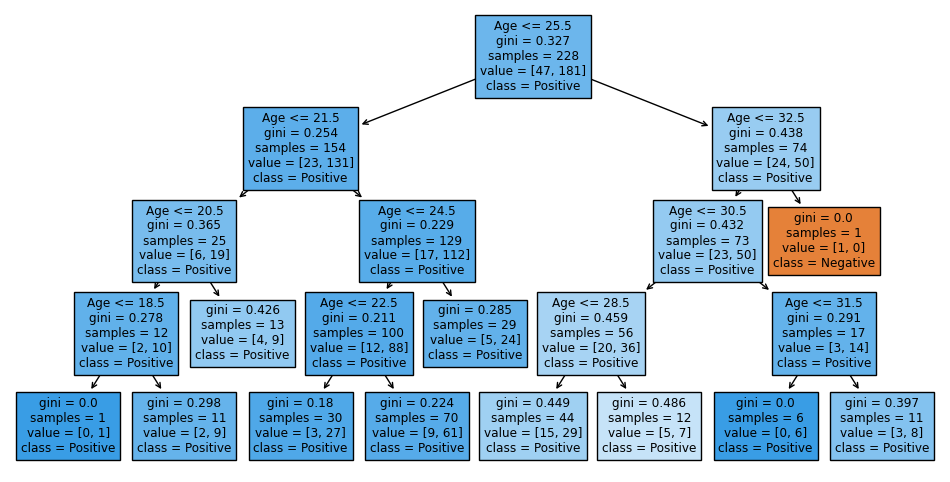

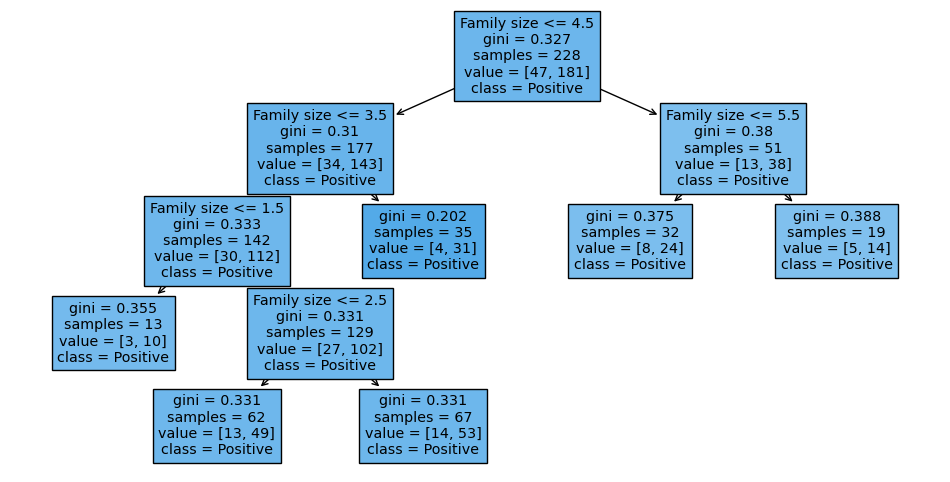

In [170]:
plt.figure(figsize=(12, 6))
plot_tree(clf_age, feature_names=['Age'], class_names=['Negative', 'Positive'], filled=True)
plt.show()

plt.figure(figsize=(12, 6))
plot_tree(clf_family_size, feature_names=['Family size'], class_names=['Negative', 'Positive'], filled=True)
plt.show()

Define function to calculate TPR, FPR and plot confusion matrix

In [171]:
def calculate_tpr_fpr(conf_matrix):
    TPR = conf_matrix[1, 1] / (conf_matrix[1, 1] + conf_matrix[1, 0])
    FPR = conf_matrix[0, 1] / (conf_matrix[0, 0] + conf_matrix[0, 1])
    return TPR, FPR

def plot_confusion_matrix(conf_matrix, title):
    plt.figure(figsize=(6, 4))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False)
    plt.title(title)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

Age Decision Tree - Train Set Accuracy: 0.7982456140350878
Age Decision Tree - Train Set True Positive Rate (TPR): 1.0
Age Decision Tree - Train Set False Positive Rate (FPR): 0.9787234042553191
Age Decision Tree - Test Set Accuracy: 0.8771929824561403
Age Decision Tree - Test Set True Positive Rate (TPR): 1.0
Age Decision Tree - Test Set False Positive Rate (FPR): 1.0


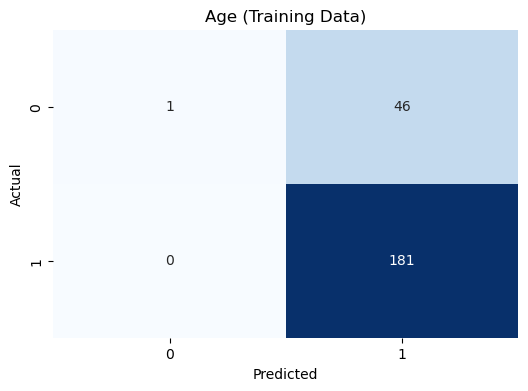

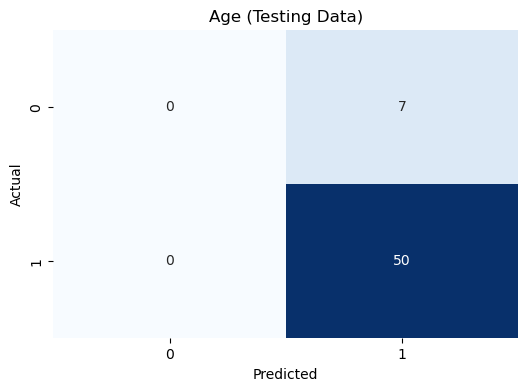

In [172]:
y_train_pred_age = clf_age.predict(X_train_age)
y_test_pred_age = clf_age.predict(X_test_age)
train_accuracy_age = accuracy_score(y_train_age, y_train_pred_age)
test_accuracy_age = accuracy_score(y_test_age, y_test_pred_age)
conf_matrix_train_age = confusion_matrix(y_train_age, y_train_pred_age)
conf_matrix_test_age = confusion_matrix(y_test_age, y_test_pred_age)
TPR_train_age, FPR_train_age = calculate_tpr_fpr(conf_matrix_train_age)
TPR_test_age, FPR_test_age = calculate_tpr_fpr(conf_matrix_test_age)

print("Age Decision Tree - Train Set Accuracy:", train_accuracy_age)
print("Age Decision Tree - Train Set True Positive Rate (TPR):", TPR_train_age)
print("Age Decision Tree - Train Set False Positive Rate (FPR):", FPR_train_age)
print("Age Decision Tree - Test Set Accuracy:", test_accuracy_age)
print("Age Decision Tree - Test Set True Positive Rate (TPR):", TPR_test_age)
print("Age Decision Tree - Test Set False Positive Rate (FPR):", FPR_test_age)

plot_confusion_matrix(conf_matrix_train_age, title='Age (Training Data)')
plot_confusion_matrix(conf_matrix_test_age, title='Age (Testing Data)')

Family Size Decision Tree - Train Set Accuracy: 0.793859649122807
Family Size Decision Tree - Train Set True Positive Rate (TPR): 1.0
Family Size Decision Tree - Train Set False Positive Rate (FPR): 1.0
Family Size Decision Tree - Test Set Accuracy: 0.8771929824561403
Family Size Decision Tree - Test Set True Positive Rate (TPR): 1.0
Family Size Decision Tree - Test Set False Positive Rate (FPR): 1.0


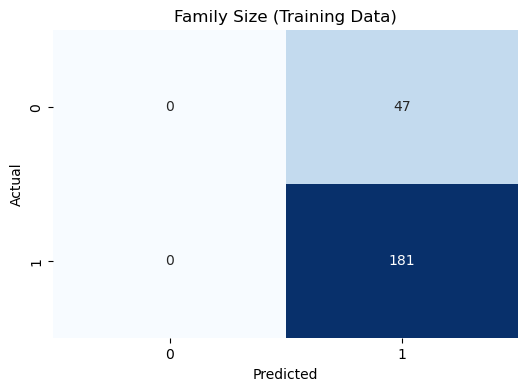

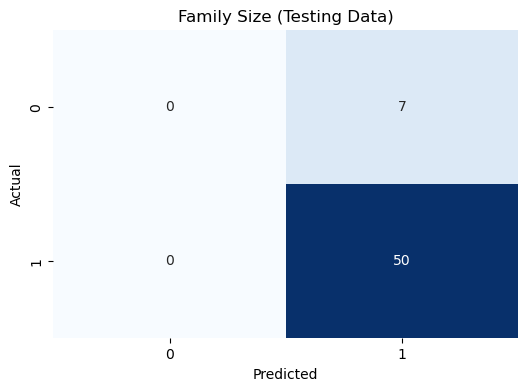

In [173]:
y_train_pred_family_size = clf_family_size.predict(X_train_family_size)
y_test_pred_family_size = clf_family_size.predict(X_test_family_size)
train_accuracy_family_size = accuracy_score(y_train_family_size, y_train_pred_family_size)
test_accuracy_family_size = accuracy_score(y_test_family_size, y_test_pred_family_size)
conf_matrix_train_family_size = confusion_matrix(y_train_family_size, y_train_pred_family_size)
conf_matrix_test_family_size = confusion_matrix(y_test_family_size, y_test_pred_family_size)
TPR_train_family_size, FPR_train_family_size = calculate_tpr_fpr(conf_matrix_train_family_size)
TPR_test_family_size, FPR_test_family_size = calculate_tpr_fpr(conf_matrix_test_family_size)

print("Family Size Decision Tree - Train Set Accuracy:", train_accuracy_family_size)
print("Family Size Decision Tree - Train Set True Positive Rate (TPR):", TPR_train_family_size)
print("Family Size Decision Tree - Train Set False Positive Rate (FPR):", FPR_train_family_size)
print("Family Size Decision Tree - Test Set Accuracy:", test_accuracy_family_size)
print("Family Size Decision Tree - Test Set True Positive Rate (TPR):", TPR_test_family_size)
print("Family Size Decision Tree - Test Set False Positive Rate (FPR):", FPR_test_family_size)

plot_confusion_matrix(conf_matrix_train_family_size, title='Family Size (Training Data)')
plot_confusion_matrix(conf_matrix_test_family_size, title='Family Size (Testing Data)')

Both the decision tree model shows high accuracy and true positive rate. However, the false positive rate is very high, suggesting misclassification issues for negative feedback predictions based on Age and Family size

To address this issue, we can use upsampling technique to balance the class distribution and enhance the model's ability to accurately predict both positive and negative feedback instances

In [174]:
df['Feedback'] = df['Feedback'].str.strip()
df_positive = df[df['Feedback'] == 'Positive']
df_negative = df[df['Feedback'] == 'Negative']

print("Number of Positive instances before upsampling:", len(df_positive))
print("Number of Negative instances before upsampling:", len(df_negative))

if not df_negative.empty:
    df_negative_upsampled = resample(df_negative, 
                                     replace=True,     
                                     n_samples=len(df_positive),  
                                     random_state=42)  
    df_upsampled = pd.concat([df_positive, df_negative_upsampled])

    print("Number of Negative instances after upsampling:", len(df_negative_upsampled))
    print("Total number of instances after upsampling:", len(df_upsampled))

Number of Positive instances before upsampling: 231
Number of Negative instances before upsampling: 54
Number of Negative instances after upsampling: 231
Total number of instances after upsampling: 462


Splitting train and test data for age after upsampling

In [175]:
X_age = df_upsampled[['Age']]
y_age = df_upsampled['Feedback']
# Train:Test = 80:20
X_train_age, X_test_age, y_train_age, y_test_age = train_test_split(X_age, y_age, test_size=0.2, random_state=42)
clf_age = DecisionTreeClassifier(max_depth=4, random_state=42)
clf_age.fit(X_train_age, y_train_age)
y_train_pred_age = clf_age.predict(X_train_age)
y_test_pred_age = clf_age.predict(X_test_age)

Age Decision Tree - Train Set Accuracy: 0.6449864498644986
Age Decision Tree - Train Set True Positive Rate (TPR): 0.7277777777777777
Age Decision Tree - Train Set False Positive Rate (FPR): 0.43386243386243384
Age Decision Tree - Test Set Accuracy: 0.5591397849462365
Age Decision Tree - Test Set True Positive Rate (TPR): 0.5882352941176471
Age Decision Tree - Test Set False Positive Rate (FPR): 0.47619047619047616


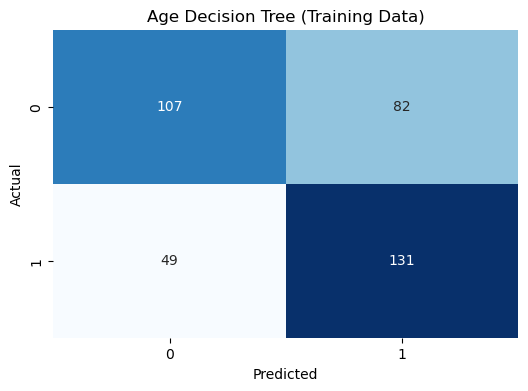

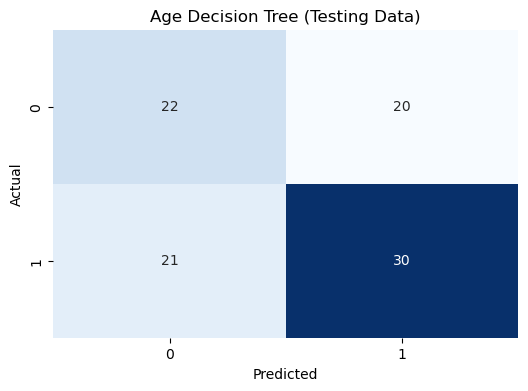

In [176]:
train_accuracy_age = accuracy_score(y_train_age, y_train_pred_age)
test_accuracy_age = accuracy_score(y_test_age, y_test_pred_age)
conf_matrix_train_age = confusion_matrix(y_train_age, y_train_pred_age)
conf_matrix_test_age = confusion_matrix(y_test_age, y_test_pred_age)
TPR_train_age, FPR_train_age = calculate_tpr_fpr(conf_matrix_train_age)
TPR_test_age, FPR_test_age = calculate_tpr_fpr(conf_matrix_test_age)

print("Age Decision Tree - Train Set Accuracy:", train_accuracy_age)
print("Age Decision Tree - Train Set True Positive Rate (TPR):", TPR_train_age)
print("Age Decision Tree - Train Set False Positive Rate (FPR):", FPR_train_age)
print("Age Decision Tree - Test Set Accuracy:", test_accuracy_age)
print("Age Decision Tree - Test Set True Positive Rate (TPR):", TPR_test_age)
print("Age Decision Tree - Test Set False Positive Rate (FPR):", FPR_test_age)

plot_confusion_matrix(conf_matrix_train_age, title='Age Decision Tree (Training Data)')
plot_confusion_matrix(conf_matrix_test_age, title='Age Decision Tree (Testing Data)')

In [177]:
X_family_size = df_upsampled[['Family size']]
y_family_size = df_upsampled['Feedback']
# Train:Test = 80:20
X_train_family_size, X_test_family_size, y_train_family_size, y_test_family_size = train_test_split(X_family_size, y_family_size, test_size=0.2, random_state=42)
clf_family_size = DecisionTreeClassifier(max_depth=4, random_state=42)
clf_family_size.fit(X_train_family_size, y_train_family_size)
y_train_pred_family_size = clf_family_size.predict(X_train_family_size)
y_test_pred_family_size = clf_family_size.predict(X_test_family_size)

Family Size Decision Tree - Train Set Accuracy: 0.5420054200542005
Family Size Decision Tree - Train Set True Positive Rate (TPR): 0.5555555555555556
Family Size Decision Tree - Train Set False Positive Rate (FPR): 0.4708994708994709
Family Size Decision Tree - Test Set Accuracy: 0.6021505376344086
Family Size Decision Tree - Test Set True Positive Rate (TPR): 0.5686274509803921
Family Size Decision Tree - Test Set False Positive Rate (FPR): 0.35714285714285715


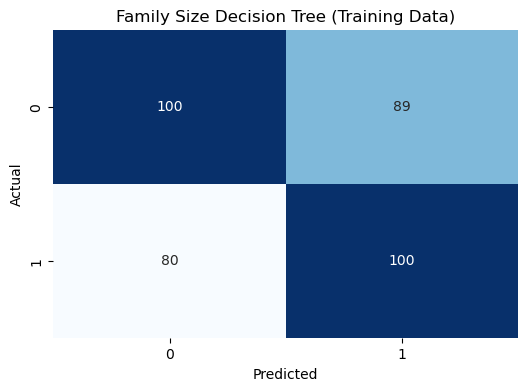

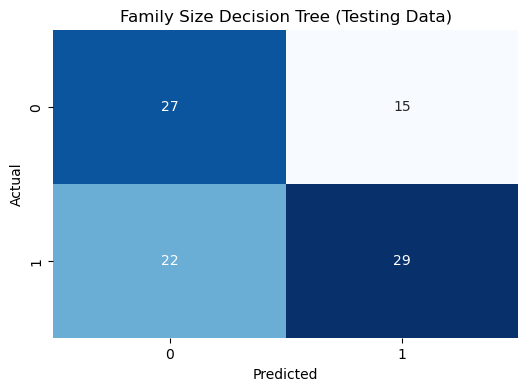

In [178]:
train_accuracy_family_size = accuracy_score(y_train_family_size, y_train_pred_family_size)
test_accuracy_family_size = accuracy_score(y_test_family_size, y_test_pred_family_size)
conf_matrix_train_family_size = confusion_matrix(y_train_family_size, y_train_pred_family_size)
conf_matrix_test_family_size = confusion_matrix(y_test_family_size, y_test_pred_family_size)
TPR_train_family_size, FPR_train_family_size = calculate_tpr_fpr(conf_matrix_train_family_size)
TPR_test_family_size, FPR_test_family_size = calculate_tpr_fpr(conf_matrix_test_family_size)

print("Family Size Decision Tree - Train Set Accuracy:", train_accuracy_family_size)
print("Family Size Decision Tree - Train Set True Positive Rate (TPR):", TPR_train_family_size)
print("Family Size Decision Tree - Train Set False Positive Rate (FPR):", FPR_train_family_size)
print("Family Size Decision Tree - Test Set Accuracy:", test_accuracy_family_size)
print("Family Size Decision Tree - Test Set True Positive Rate (TPR):", TPR_test_family_size)
print("Family Size Decision Tree - Test Set False Positive Rate (FPR):", FPR_test_family_size)

plot_confusion_matrix(conf_matrix_train_family_size, title='Family Size Decision Tree (Training Data)')
plot_confusion_matrix(conf_matrix_test_family_size, title='Family Size Decision Tree (Testing Data)')

The model's performance has generally improved after upsampling. There is a significant decrease in FPR for both the Train and Test sets. However, there is a significant discrepancy between the Train and Train datasets, suggesting potential overfitting

# Random Forest

Random Forest (Age) - Train Set Accuracy: 0.6476964769647696
Random Forest (Age) - Train Set True Positive Rate (TPR): 0.6777777777777778
Random Forest (Age) - Train Set False Positive Rate (FPR): 0.38095238095238093
Random Forest (Age) - Test Set Accuracy: 0.6021505376344086
Random Forest (Age) - Test Set True Positive Rate (TPR): 0.5882352941176471
Random Forest (Age) - Test Set False Positive Rate (FPR): 0.38095238095238093


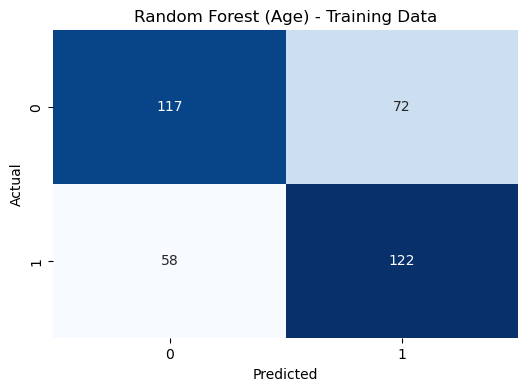

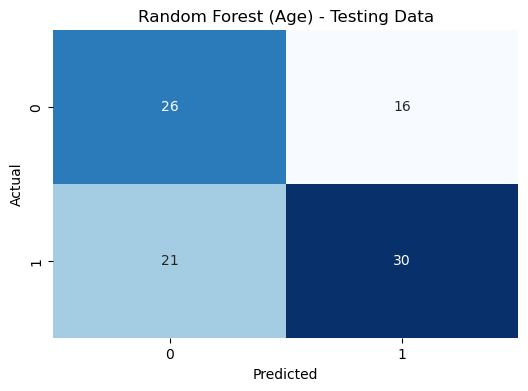

In [179]:
rf_clf_age = RandomForestClassifier(n_estimators=100, random_state=42)
rf_clf_age.fit(X_train_age, y_train_age)
y_train_pred_rf_age = rf_clf_age.predict(X_train_age)
y_test_pred_rf_age = rf_clf_age.predict(X_test_age)
train_accuracy_rf_age = accuracy_score(y_train_age, y_train_pred_rf_age)
test_accuracy_rf_age = accuracy_score(y_test_age, y_test_pred_rf_age)
conf_matrix_train_rf_age = confusion_matrix(y_train_age, y_train_pred_rf_age)
conf_matrix_test_rf_age = confusion_matrix(y_test_age, y_test_pred_rf_age)
TPR_train_rf_age, FPR_train_rf_age = calculate_tpr_fpr(conf_matrix_train_rf_age)
TPR_test_rf_age, FPR_test_rf_age = calculate_tpr_fpr(conf_matrix_test_rf_age)

print("Random Forest (Age) - Train Set Accuracy:", train_accuracy_rf_age)
print("Random Forest (Age) - Train Set True Positive Rate (TPR):", TPR_train_rf_age)
print("Random Forest (Age) - Train Set False Positive Rate (FPR):", FPR_train_rf_age)
print("Random Forest (Age) - Test Set Accuracy:", test_accuracy_rf_age)
print("Random Forest (Age) - Test Set True Positive Rate (TPR):", TPR_test_rf_age)
print("Random Forest (Age) - Test Set False Positive Rate (FPR):", FPR_test_rf_age)

plot_confusion_matrix(conf_matrix_train_rf_age, title='Random Forest (Age) - Training Data')
plot_confusion_matrix(conf_matrix_test_rf_age, title='Random Forest (Age) - Testing Data')


Random Forest (Family Size) - Train Set Accuracy: 0.5420054200542005
Random Forest (Family Size) - Train Set True Positive Rate (TPR): 0.5555555555555556
Random Forest (Family Size) - Train Set False Positive Rate (FPR): 0.4708994708994709
Random Forest (Family Size) - Test Set Accuracy: 0.6021505376344086
Random Forest (Family Size) - Test Set True Positive Rate (TPR): 0.5686274509803921
Random Forest (Family Size) - Test Set False Positive Rate (FPR): 0.35714285714285715


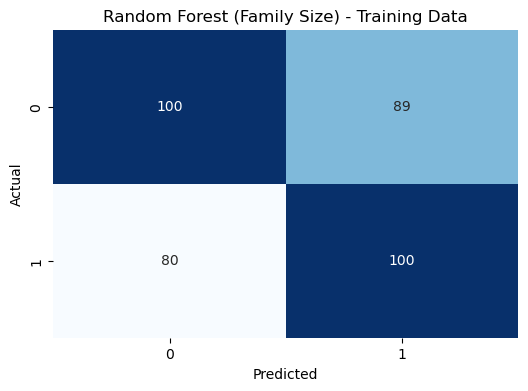

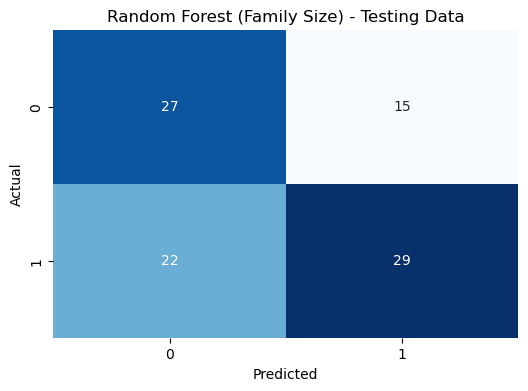

In [180]:
rf_clf_family_size = RandomForestClassifier(n_estimators=100, random_state=42)
rf_clf_family_size.fit(X_train_family_size, y_train_family_size)
y_train_pred_rf_family_size = rf_clf_family_size.predict(X_train_family_size)
y_test_pred_rf_family_size = rf_clf_family_size.predict(X_test_family_size)
train_accuracy_rf_family_size = accuracy_score(y_train_family_size, y_train_pred_rf_family_size)
test_accuracy_rf_family_size = accuracy_score(y_test_family_size, y_test_pred_rf_family_size)
conf_matrix_train_rf_family_size = confusion_matrix(y_train_family_size, y_train_pred_rf_family_size)
conf_matrix_test_rf_family_size = confusion_matrix(y_test_family_size, y_test_pred_rf_family_size)
TPR_train_rf_family_size, FPR_train_rf_family_size = calculate_tpr_fpr(conf_matrix_train_rf_family_size)
TPR_test_rf_family_size, FPR_test_rf_family_size = calculate_tpr_fpr(conf_matrix_test_rf_family_size)

print("Random Forest (Family Size) - Train Set Accuracy:", train_accuracy_rf_family_size)
print("Random Forest (Family Size) - Train Set True Positive Rate (TPR):", TPR_train_rf_family_size)
print("Random Forest (Family Size) - Train Set False Positive Rate (FPR):", FPR_train_rf_family_size)
print("Random Forest (Family Size) - Test Set Accuracy:", test_accuracy_rf_family_size)
print("Random Forest (Family Size) - Test Set True Positive Rate (TPR):", TPR_test_rf_family_size)
print("Random Forest (Family Size) - Test Set False Positive Rate (FPR):", FPR_test_rf_family_size)

plot_confusion_matrix(conf_matrix_train_rf_family_size, title='Random Forest (Family Size) - Training Data')
plot_confusion_matrix(conf_matrix_test_rf_family_size, title='Random Forest (Family Size) - Testing Data')

The Random Forest model shows moderate accuracy and true positive rate. There is also a reduction in the discrepancy between the train and test datasets compared to the Decision Tree model, suggesting improved performance across the data

# Logistic Regression

Splitting train and test data for categorical predictors

In [181]:
cate_pred = df[['Monthly Income', 'Occupation', 'Marital Status']]
cate_pred = pd.get_dummies(cate_pred)
resp = df['Feedback'] 
train_pred, test_pred, train_resp, test_resp = train_test_split(cate_pred, resp, test_size=0.25, random_state=42)

In [182]:
lr = LogisticRegression()
lr.fit(train_pred, train_resp)
coefficients = pd.DataFrame(lr.coef_, columns=train_pred.columns)
coefficients = coefficients.T.sort_values(by=0, ascending=False)
train_accuracy = lr.score(train_pred, train_resp)
test_accuracy = lr.score(test_pred, test_resp)
print("Accuracy on the train set:", train_accuracy)
print("Accuracy on the test set:", test_accuracy)

Accuracy on the train set: 0.8028169014084507
Accuracy on the test set: 0.8611111111111112


In [183]:
print("# Rank of importance of categorical predictors")
for i, (feature, coef) in enumerate(zip(coefficients.index, coefficients[0]), 1):
    print(f"{i} : {feature} = {coef:.4f}")

# Rank of importance of categorical predictors
1 : Occupation_House wife = 0.7495
2 : Monthly Income_More than 50000 = 0.5880
3 : Marital Status_Single = 0.4585
4 : Monthly Income_No Income = 0.1848
5 : Occupation_Student = 0.1736
6 : Monthly Income_25001 to 50000 = 0.0825
7 : Monthly Income_10001 to 25000 = 0.0263
8 : Marital Status_Married = -0.1597
9 : Marital Status_Prefer not to say = -0.2989
10 : Occupation_Employee = -0.3289
11 : Occupation_Self Employeed = -0.5942
12 : Monthly Income_Below Rs.10000 = -0.8816


In [184]:
resp_pred = lr.predict(test_pred)
print("\nPerformance metrics:")
print(classification_report(test_resp, resp_pred))


Performance metrics:
              precision    recall  f1-score   support

    Negative       1.00      0.09      0.17        11
    Positive       0.86      1.00      0.92        61

    accuracy                           0.86        72
   macro avg       0.93      0.55      0.55        72
weighted avg       0.88      0.86      0.81        72



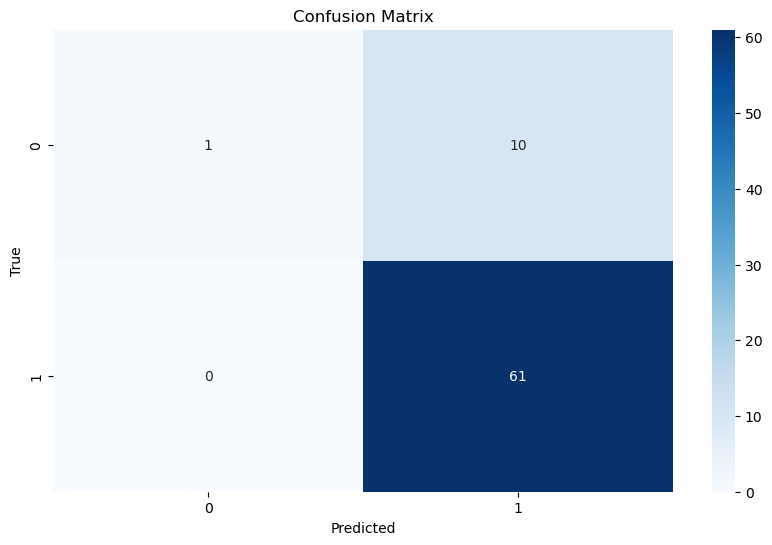

In [186]:
cm = confusion_matrix(test_resp, resp_pred)
plt.figure(figsize=(10, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()